# Title : Categorizing and search engine for the Covid-19 research papers

## Goal:

Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can clustering the similar research articles together simplify the search for related publications? How can the content of the clusters be qualified?

By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

By using Bokeh, the plot will be interactive. User’s will have the option of seeing the plot as a whole or filtering the data by cluster. If a narrower scope is required, the plot will also have a search function which will limit the output to only papers containing the search term. Hovering over points on the plot will give basic information like title, author, journal, and abstract. Clicking on a point will bring up a menu with a URL that can be used to access the full publication.

This is a difficult time in which health care workers, sanitation staff, and many other essential personnel are out there keeping the world afloat. While adhering to quarantine protocol, the Kaggle CORD-19 competition has given us an opportunity to help in the best way we can as computer science students. It should be noted, however, that we are not epidemiologists, and it is not our place to gauge the importance of these papers. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.


### Why I did this project:

Companies, Eductional institutions and many organizations are being flooded with large corpora of text daily and they need data science tools to draw valuable insights from the data and take key decisions to develop business and inturn improve the customer satisfaction towards the company's product. This project aims at dealing with similar kind of problem except that we are doing this project with covid-19 research papers.

## Approach:

- Parse the text from the body of each document using Natural Language Processing (NLP).

- Turn each document instance  𝑑𝑖  into a feature vector  𝑋𝑖  using Term Frequency–inverse Document Frequency (TF-IDF).

- Apply Dimensionality Reduction to each feature vector  𝑋𝑖  using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane  𝑋  embedding  𝑌1 .

- Use Principal Component Analysis (PCA) to project down the dimensions of  𝑋  to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding  𝑌2 .

- Apply k-means clustering on  𝑌2 , where  𝑘  is 20, to label each cluster on  𝑌1 .

- Apply Topic Modeling on  𝑋  using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster.

- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD).


In [1]:
from IPython.display import Image


## Workflow of data science:

Below is the diagram depicting the different stages in data science life cycle. I will explain different techniques corresponding to each stage after the image.


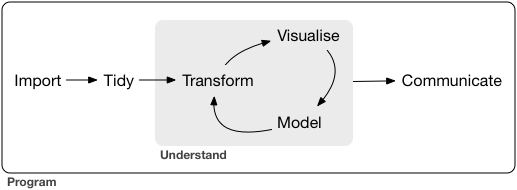

In [2]:
Image(filename = '../input/markdown-images/data-science.png',height = 500, width = 1000 )

### Different stages explained w.r.t to data science cycle and respective techniques:

**Import stage :**

- Loading the data

**Tidy stage :**

- Rename the columns and rows if needed

- By end of this stage, make sure to keep each sample to be in a row and each variable in a column and each value is in a cell
    
**Transform stage :**

- Remove outliers 

- Feature Selection/sample selection either filtering or subsetting
    
    - Remove unwanted data

- arrange the data samples, if needed

- Feature Engineering

    - Imputing data (Deal with NaN values)
    
    - compute new variable based on existing variables

    - Vectorization or embedding

    - Dimensionality reduction (PCA,SVD,...)

- Compute Summary statistics for variables of interest

**Visualization :**

- Check for relationship between variables

- Dimensionality Reduction with t-SNE

**Modelling stage :**

- Clustering (can be considered as part of 'EDA') 

- Topic Modeling on Each Cluster
    
- Classify
    
**Communicate findings :**

- Plot

- How to Use the Plot?

- Conclusion/Results
    
#### Interesting Facts :

- Statisticians often love to call the Import, Tidy and Transform Stages as  **"Data Wrangling"** - Due to the reason that we often scrap and battle with raw data to make our data to be in precise and useful format for our further stages of data science cycle.

- They also like to call the iterative stage between Transform and Visualization as **"Exploratory Data Analysis (EDA)"** - Due to fact that, we explore the data to derive the insights.

- Feature Engineering is about creating new variables in data, whereas, feature selection is about selecting subset of features based on their importance or correlations **(Caution: Neither Association nor Correlation doesn't mean causation!!!!)**

- Look for the normality in the data and remove the outliers from data during EDA stage.
    


## Dataset description: 

Dataset is taken from kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 187,000 scholarly articles, including over 82,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

## Import the required libraries (Atleast the most common ones)



In [3]:
## For the analysis
import numpy as np 
import pandas as pd 
import glob
import json

## For basic visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Loading the data


- It is quite intimidating to see all the data collected. In my perspective, it is always better to understand the data that we have in hand first before jumping into any further steps. 

- So, load the metadata file and know about the available data at high-level and reason whether we can solve problem with this available data

In [4]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195711 entries, 0 to 195710
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          195711 non-null  object 
 1   sha               82517 non-null   object 
 2   source_x          195711 non-null  object 
 3   title             195655 non-null  object 
 4   doi               139395 non-null  object 
 5   pmcid             87299 non-null   object 
 6   pubmed_id         119076 non-null  object 
 7   license           195711 non-null  object 
 8   abstract          139874 non-null  object 
 9   publish_time      195693 non-null  object 
 10  authors           189141 non-null  object 
 11  journal           184692 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  51738 non-null   object 
 14  arxiv_id          2500 non-null    object 
 15  pdf_json_files    82517 non-null   object 
 16  pmc_json_files    63

## Exploratory Data Analysis - Transform and visualization

Hint: Iteratively, ask questions about the data and find the solutions to those questions

- Mostly, we will be using the "abstract" of each research paper, due to the fact that the authors of article will briefly summarize about their work in the form of abstract and it is more efficient in terms of computation requirement.

- Analyse the abstracts written by the authors and remove if there any duplicates 

In [6]:
## Check the unique records match the number of actual records.

meta_df['abstract'].describe(include = 'all')

count      139874
unique     127534
top       Unknown
freq          124
Name: abstract, dtype: object

In [7]:
### Remove duplicate records

meta_df.drop_duplicates(['abstract'] ,inplace = True)

In [8]:
meta_df['abstract'].describe(include='all')

count                                                127534
unique                                               127534
top       Coccidiosis is an economically significant dis...
freq                                                      1
Name: abstract, dtype: object

In [9]:
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [10]:
### Subset the samples randomly (since, running on the whole dataset is not feasible in kaggle)

subset_data_df = meta_df.sample(1000, random_state = 10)


In [11]:
subset_data_df.isna().sum()

cord_uid               0
sha                  509
source_x               0
title                  0
doi                  202
pmcid                528
pubmed_id            270
license                0
abstract               0
publish_time           0
authors                6
journal               63
mag_id              1000
who_covidence_id     843
arxiv_id             982
pdf_json_files       509
pmc_json_files       629
url                  113
s2_id                134
dtype: int64

In [12]:
### Remove the records with NaN values

subset_data_df.dropna(how='all', subset = ['abstract', 'title', 'authors'], inplace = True)
subset_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 6267 to 178213
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          1000 non-null   object 
 1   sha               491 non-null    object 
 2   source_x          1000 non-null   object 
 3   title             1000 non-null   object 
 4   doi               798 non-null    object 
 5   pmcid             472 non-null    object 
 6   pubmed_id         730 non-null    object 
 7   license           1000 non-null   object 
 8   abstract          1000 non-null   object 
 9   publish_time      1000 non-null   object 
 10  authors           994 non-null    object 
 11  journal           937 non-null    object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  157 non-null    object 
 14  arxiv_id          18 non-null     object 
 15  pdf_json_files    491 non-null    object 
 16  pmc_json_files    371 non-null    obj

##### So, what about the different languages in our text?

- Get the distribution plot explaining the number of records that belong to each language

In [13]:
!pip install spacy-langdetect

     |████████████████████████████████| 998 kB 2.8 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993461 sha256=28db0ebfcc1a65d62feae1563e57a2d9a893a18010910e407e8d2cca35d8c0dc
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect


In [14]:
from tqdm import tqdm
from pprint import pprint
import spacy
from spacy_langdetect import LanguageDetector

def language_detection(df, column_name = None , num_tokens = 50,  plot = True):
    """
    Takes in the dataframe and output the dataframe with languages for each record based on the mentioned text column name with starting "num_tokens" words
    """

    # hold label - language
    languages = []

    # go through each text
    for idx in tqdm(range(0,len(df))):
        # split by space into list, take the first x intex, join with space
        text = df.iloc[idx][column_name]
        
        nlp = spacy.load('en')
        
        ## since, it is time consuming, we detect the language using only starting "num_tokens"
        initial_text = text.split(' ')[:num_tokens]
        
        nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
        # process the text
        doc = nlp(" ".join(initial_text))
        
        # get the language  
        lang = doc._.language['language']
        languages.append(lang)
    
    df['language'] = languages
    languages_dict = {}
    if plot == True :
        for lang in set(languages):
            languages_dict[lang] = languages.count(lang)

        print("Total: {}\n".format(len(languages)))
        pprint(languages_dict)
        plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
        plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
        plt.title("Distribution of Languages in Dataset")
        plt.xlabel("Languages")
        plt.ylabel("Number of records")
        plt.show()
    return df, languages, languages_dict

100%|██████████| 1000/1000 [18:28<00:00,  1.11s/it]


Total: 1000

{'de': 6, 'en': 986, 'es': 3, 'fr': 2, 'nl': 1, 'tr': 1, 'zh-cn': 1}


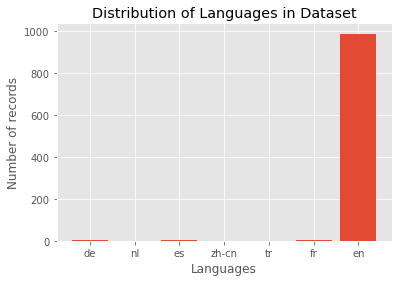

In [15]:

lang_detected_data_df, lang_series, lang_dict = language_detection(subset_data_df, column_name = 'abstract', num_tokens = 50, plot = True)

In [16]:
## Filter the dataset for only english records

filtered_data_df = lang_detected_data_df[lang_detected_data_df['language'] == 'en']
filtered_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 6267 to 178213
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          986 non-null    object 
 1   sha               484 non-null    object 
 2   source_x          986 non-null    object 
 3   title             986 non-null    object 
 4   doi               786 non-null    object 
 5   pmcid             462 non-null    object 
 6   pubmed_id         726 non-null    object 
 7   license           986 non-null    object 
 8   abstract          986 non-null    object 
 9   publish_time      986 non-null    object 
 10  authors           982 non-null    object 
 11  journal           924 non-null    object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  152 non-null    object 
 14  arxiv_id          18 non-null     object 
 15  pdf_json_files    484 non-null    object 
 16  pmc_json_files    369 non-null    obje

In [50]:
filtered_data_df.to_csv('filtered_data_df.csv')

##### Common issue dealing with text : What about the stop words ?

In [17]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [18]:
punctuations = string.punctuation
stop_words = list(STOP_WORDS)

In [19]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www', 'objective', 'abstract'
]

for w in custom_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [20]:
# Download the spacy bio parser 
# Ref: https://allenai.github.io/scispacy/

# !pip install scispacy

### or ####

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
import en_core_sci_lg

In [21]:
!pip install scispacy
!pip install en_core_sci_lg

     |████████████████████████████████| 9.9 MB 41 kB/s  eta 0:00:01     |▍                               | 133 kB 6.4 MB/s eta 0:00:02
     |████████████████████████████████| 13.0 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 34.8 MB/s eta 0:00:01
ERROR: allennlp 1.0.0 has requirement spacy<2.3,>=2.1.0, but you'll have spacy 2.3.2 which is incompatible.
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [22]:
import scispacy
import en_core_sci_lg

In [23]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [24]:
### Apply the tokenizer function to the text data

tqdm.pandas()


filtered_data_df["processed_text"] = filtered_data_df["abstract"].progress_apply(spacy_tokenizer)



/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 986/986 [00:23<00:00, 41.17it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
filtered_data_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,language,processed_text
6267,kfbu10oy,b9dc9aa5d1b93da55c2e39080592a5044a98771e,PMC,2009 Pandemic influenza in India,10.1007/s13312-010-0007-4,PMC7097275,20139474,no-cc,Pandemic-09-H1N1 virus caused the pandemic sta...,2010-05-06,...,Indian Pediatr,NaN,NaN,NaN,document_parses/pdf_json/b9dc9aa5d1b93da55c2e3...,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,en,pandemic-09-h1n1 virus cause pandemic start 2 ...
37843,5trwxede,NaN,Medline,Use of parallel grafts to save failed prior en...,10.1016/j.jvs.2015.04.395,NaN,26087878,unk,OBJECTIVE The aim of this study was the evalua...,2015,...,Journal of vascular surgery,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1016/j.jvs.2015.04.395; htt...,13246931.0,en,aim study evaluation clinical radiologic outco...
47062,5w1y5y0h,NaN,Medline,Reducing overcrowding in an emergency departme...,10.1590/1806-9282.65.12.1476,NaN,31994629,unk,OBJECTIVE Exploring the use of forecasting mod...,2019-12-01,...,Revista da Associacao Medica Brasileira,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1590/1806-9282.65.12.1476; ...,210945711.0,en,exploring use forecast model simulation tool e...
142566,bf5rct4q,de71ae7b74fdc75b489351a1ac5a1b98c76ccfc3,Elsevier; Medline; PMC,Shuffling multivariate adaptive regression spl...,10.1016/j.jpba.2009.07.009,PMC7126869,19665859,els-covid,"Abstract In this work, the inhibitory activity...",2009-12-05,...,Journal of Pharmaceutical and Biomedical Analysis,NaN,NaN,NaN,document_parses/pdf_json/de71ae7b74fdc75b48935...,document_parses/pmc_json/PMC7126869.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/19665859/;...,159732.0,en,work inhibitory activity pyridine n-oxide deri...
66575,f0aaf1dm,NaN,Medline,Single-port laparoscopic surgery in children: ...,10.1155/2012/232347,NaN,22778945,unk,Single-incision laparoscopic surgery (SILS) is...,2012,...,Minimally invasive surgery,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1155/2012/232347; https://w...,16681645.0,en,single-incision laparoscopic surgery sils emer...


##### So, what's the "number of total words per document" over all articles?

In [26]:
import seaborn as sns

In [27]:
### Count the number of words that really useful for further stages

filtered_data_df['words_count'] = filtered_data_df['processed_text'].apply(lambda x : len(x.strip().split()))


filtered_data_df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,language,processed_text,words_count
6267,kfbu10oy,b9dc9aa5d1b93da55c2e39080592a5044a98771e,PMC,2009 Pandemic influenza in India,10.1007/s13312-010-0007-4,PMC7097275,20139474,no-cc,Pandemic-09-H1N1 virus caused the pandemic sta...,2010-05-06,...,NaN,NaN,NaN,document_parses/pdf_json/b9dc9aa5d1b93da55c2e3...,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,en,pandemic-09-h1n1 virus cause pandemic start 2 ...,83
37843,5trwxede,NaN,Medline,Use of parallel grafts to save failed prior en...,10.1016/j.jvs.2015.04.395,NaN,26087878,unk,OBJECTIVE The aim of this study was the evalua...,2015,...,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1016/j.jvs.2015.04.395; htt...,13246931.0,en,aim study evaluation clinical radiologic outco...,187
47062,5w1y5y0h,NaN,Medline,Reducing overcrowding in an emergency departme...,10.1590/1806-9282.65.12.1476,NaN,31994629,unk,OBJECTIVE Exploring the use of forecasting mod...,2019-12-01,...,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1590/1806-9282.65.12.1476; ...,210945711.0,en,exploring use forecast model simulation tool e...,165
142566,bf5rct4q,de71ae7b74fdc75b489351a1ac5a1b98c76ccfc3,Elsevier; Medline; PMC,Shuffling multivariate adaptive regression spl...,10.1016/j.jpba.2009.07.009,PMC7126869,19665859,els-covid,"Abstract In this work, the inhibitory activity...",2009-12-05,...,NaN,NaN,NaN,document_parses/pdf_json/de71ae7b74fdc75b48935...,document_parses/pmc_json/PMC7126869.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/19665859/;...,159732.0,en,work inhibitory activity pyridine n-oxide deri...,150
66575,f0aaf1dm,NaN,Medline,Single-port laparoscopic surgery in children: ...,10.1155/2012/232347,NaN,22778945,unk,Single-incision laparoscopic surgery (SILS) is...,2012,...,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1155/2012/232347; https://w...,16681645.0,en,single-incision laparoscopic surgery sils emer...,40


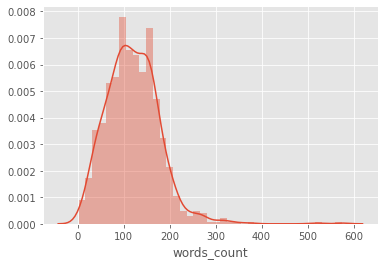

In [28]:
### PLot the counts to know the distribution of words per document
sns.distplot(filtered_data_df['words_count'])

In [29]:
### Print from summary statistics

filtered_data_df['words_count'].describe()

count    986.000000
mean     120.364097
std       58.402840
min        2.000000
25%       80.000000
50%      118.000000
75%      155.000000
max      575.000000
Name: words_count, dtype: float64

At average, there are 106 (median) words per article. The average number of words for all articles is 108 (mean).

##### What's the count for each country?

##### We can ask many more questions like this... and get the answers through analysis

### Vectorize the text

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, max_num_features ):
    vectorizer = TfidfVectorizer(max_features=max_num_features)
    text_vectorized = vectorizer.fit_transform(text)
    return text_vectorized

In [31]:
text = filtered_data_df['processed_text'].values

#### 
median_from_distplot = 106
# -------------------------

text_vectorized_csr = vectorize(text, median_from_distplot)
text_vectorized_csr.shape

(986, 106)

In [32]:
### Convert CSR matrix to NdArray
text_vectorized_df = text_vectorized_csr.toarray()

print(text_vectorized_df.shape)
print(type(text_vectorized_df))

(986, 106)
<class 'numpy.ndarray'>


## Modelling

### Clustering

In [33]:
## Install scikit-learn, if not installed.
# pip3 install scikit-learn 


import sklearn
print(sklearn.__version__)
np.random.seed(10)

0.23.1


In [34]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [35]:
## Functional implementations for plotting Inertia and silhoutte score for visual interpretation

## For Inertia
def inertia_plot( model, X, start = 2, stop = 10, kmeans_init = 'random'):
    #A simple inertia plotter to decide K in KMeans
    inertia = []
    for x in range(start,stop):
        km = model(n_clusters = x, init = kmeans_init )
        labels = km.fit_predict(X)
        inertia.append(km.inertia_)
    plt.figure(figsize = (10,6))
    plt.plot(range(start,stop), inertia, marker = 'o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia Decrease with K')
    plt.xticks(list(range(start, stop)))
    plt.show()
    
    
    
## For Silhoutte score

def silhoutte_scores_plots(model,  X, start=2, stop=5, metric = 'euclidean'):
    # Taken from sebastian Raschkas book Python Machine Learning second edition
    for x in range(start, stop):
        km = model(n_clusters = x)
        y_km = km.fit_predict(X)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(X, y_km))
        cluster_labels = np.unique(y_km)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y_km, metric = metric)
        y_ax_lower, y_ax_upper =0,0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i)/n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height=1.0,
                    edgecolor='none',
                    color = color)
            yticks.append((y_ax_lower + y_ax_upper)/2.)
            y_ax_lower+= len(c_silhouette_vals)

        silhouette_avg = np.mean(silhouette_vals)
        plt.axvline(silhouette_avg,
                   color = 'red',
                   linestyle = "--")
        plt.yticks(yticks, cluster_labels+1)
        plt.ylabel("cluster")
        plt.xlabel('Silhouette Coefficient')
        plt.title('Silhouette for ' + str(x) + " Clusters")
        plt.show()

For random seed choice of centroids initialization


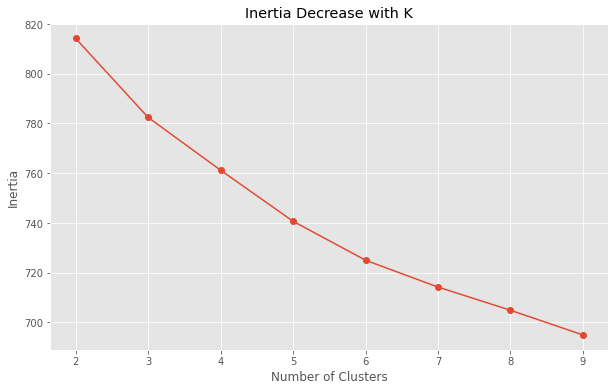

For "kmeans++" seed choice of centroids initialization


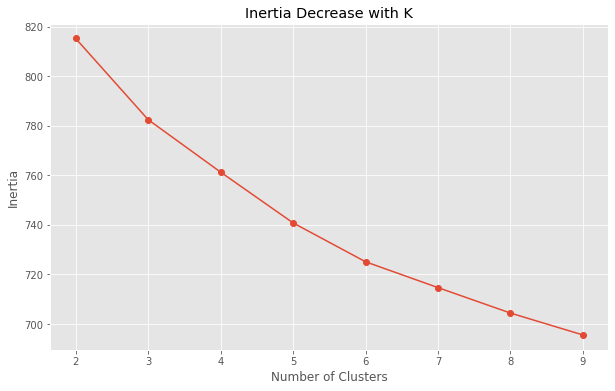

In [36]:
### Fit KMeans
kmeans_model = KMeans
print("For random seed choice of centroids initialization")
inertia_plot(kmeans_model, text_vectorized_df)


print("For \"kmeans++\" seed choice of centroids initialization")
inertia_plot(kmeans_model, text_vectorized_df, kmeans_init = 'k-means++')

Silhouette-Score for 2 Clusters:  0.03693431829600864


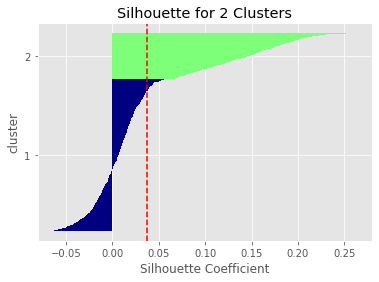

Silhouette-Score for 3 Clusters:  0.049322362090751574


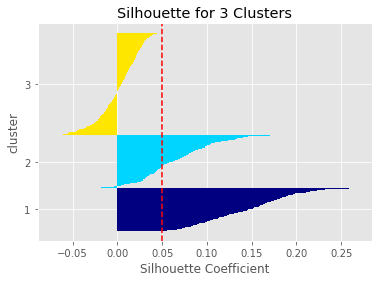

Silhouette-Score for 4 Clusters:  0.051557155262507134


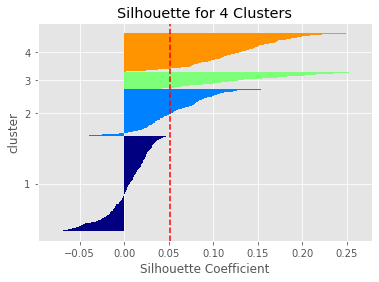

Silhouette-Score for 5 Clusters:  0.055084185681767324


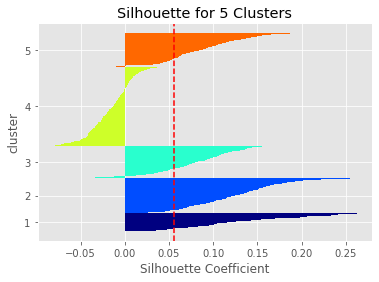

Silhouette-Score for 6 Clusters:  0.057807941902682715


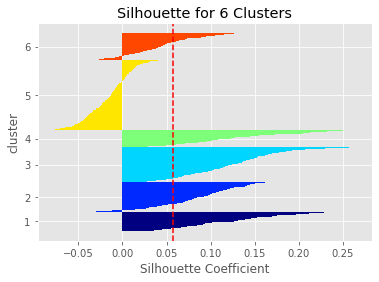

Silhouette-Score for 7 Clusters:  0.06296285995493282


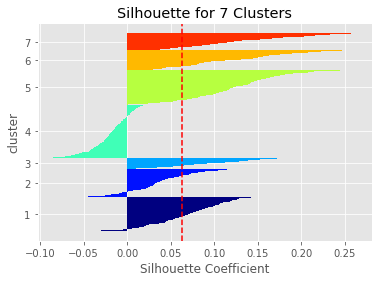

Silhouette-Score for 8 Clusters:  0.062379859594115655


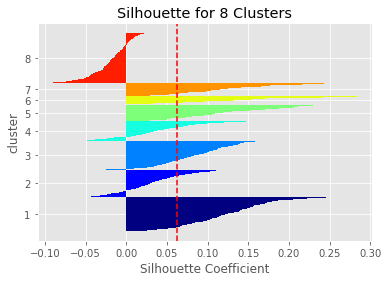

Silhouette-Score for 9 Clusters:  0.06504326771653578


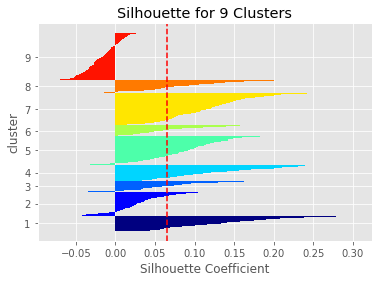

In [37]:
silhoutte_scores_plots(kmeans_model, text_vectorized_df, start = 2, stop = 10)

### Dimensionality reduction for visualization with t-SNE

In [58]:
### Function to reduce the dimensions of data

from sklearn.manifold import TSNE
import seaborn as sns

def tsne_plot(X, labels = None, k_selected = None, cluster_colors = False):
    
    # Initialize tsne
    tsne = TSNE(verbose=1, perplexity=20, random_state=42)
    
    X_tsne_embedded = tsne.fit_transform(X)
    
    # sns settings
    sns.set(rc={'figure.figsize':(15,15)})
    
    if (cluster_colors == False) :
        # colors
        palette = sns.color_palette("bright", 1)
        # plot
        sns.scatterplot(X_tsne_embedded[:,0], X_tsne_embedded[:,1], palette=palette)
        plt.title('t-SNE with no Labels')
        
    elif (cluster_colors == True) :
        # colors
        category_range = np.arange(k_selected)
        # cluster_sign = 'Cluster-'
        #category_labels = map(''.join, zip(cluster_sign, category_range)) 
        palette = sns.color_palette("husl", k_selected)
        # palette = sns.hls_palette(k_selected, h = 0.01, l=.4, s=.9)
        # plot
        sns.scatterplot(X_tsne_embedded[:,0], X_tsne_embedded[:,1], hue=labels, legend='full')
        plt.title('t-SNE with Kmeans Labels')
    
    plt.show()
    return X_tsne_embedded

In [59]:
### Function to plot the samples as scatter plot showing the clusters with different colors
def fit_and_plot(model, X, k_selected = None):
    """This function takes the model and data samples as the input and shows a scatter plot depicting the clusters in samples"""
    # fit the model
    # model.fit(X)
    # assign a cluster to each example
    labels = model.fit_predict(X)
    
    # Original data samples on tsne-plot
    X_tsne_embedded = tsne_plot(X)
    
    # Clustered data samples on tsne-plot
    X_tsne_embedded = tsne_plot(X, labels = labels, k_selected = k_selected, cluster_colors = True)
    return X_tsne_embedded
    

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.011s...
[t-SNE] Computed neighbors for 986 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 0.327265
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.036560
[t-SNE] KL divergence after 1000 iterations: 1.560530


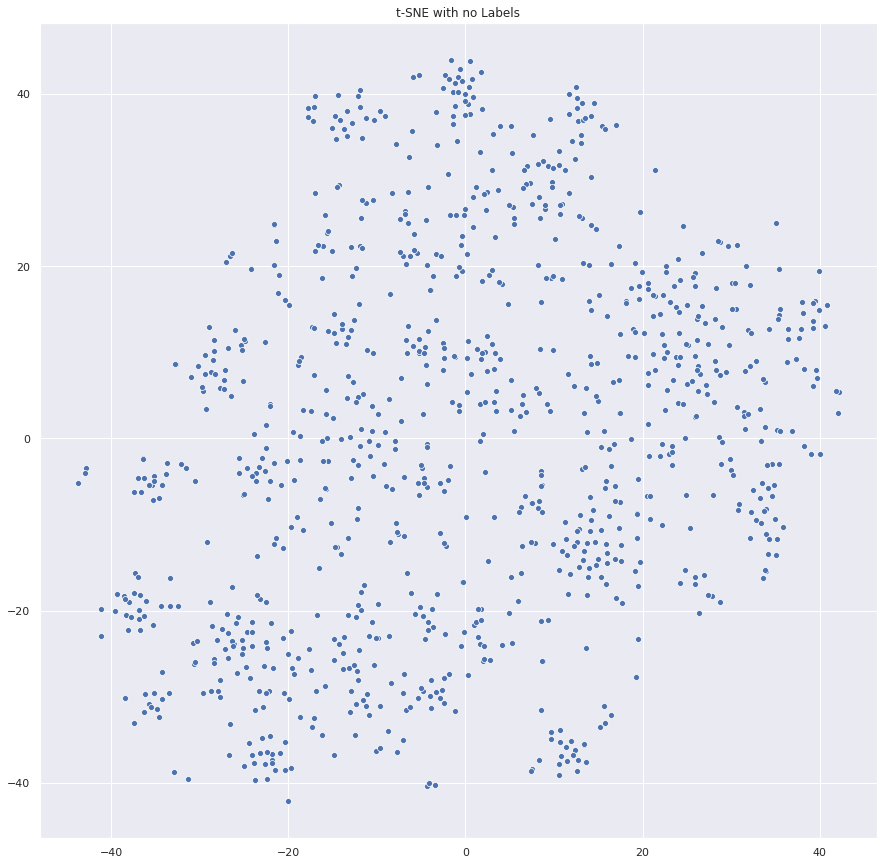

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.008s...
[t-SNE] Computed neighbors for 986 samples in 0.249s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 0.327265
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.036560
[t-SNE] KL divergence after 1000 iterations: 1.560530


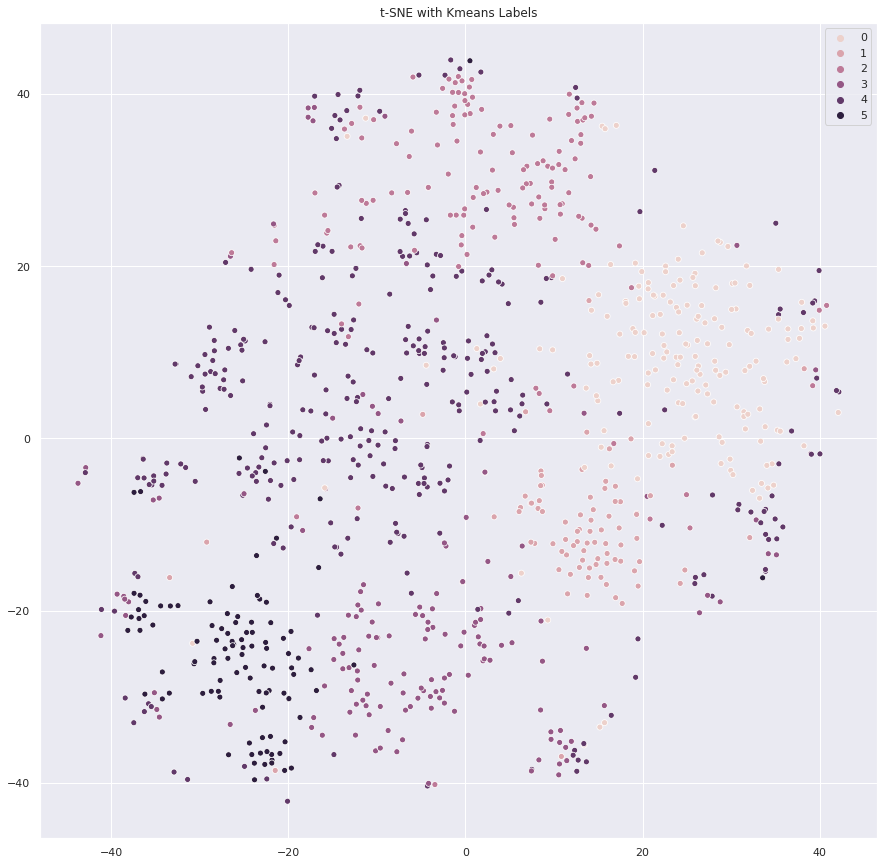

In [60]:
### Since, we choose k = 6

optimal_k = 6

_ = fit_and_plot(kmeans_model(n_clusters = optimal_k), X = text_vectorized_df, k_selected = optimal_k)

In [154]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the min-max scaler and scale the data to (0, 1) range
# min_max_scaler = MinMaxScaler(feature_range = (0, 1))

standard_scaler = StandardScaler(with_mean = True, with_std = True)

text_vectorized_df_scaled = standard_scaler.fit_transform(text_vectorized_df)

# Initialize the PCA 
pca_method = PCA(n_components = 0.99, random_state = 10)


# Apply PCA to the data and store the reduced dimensional data
text_vectorized_dims_red = pca_method.fit_transform(text_vectorized_df_scaled)

print(text_vectorized_dims_red.shape)

(986, 101)


For random choice of centroids initialization


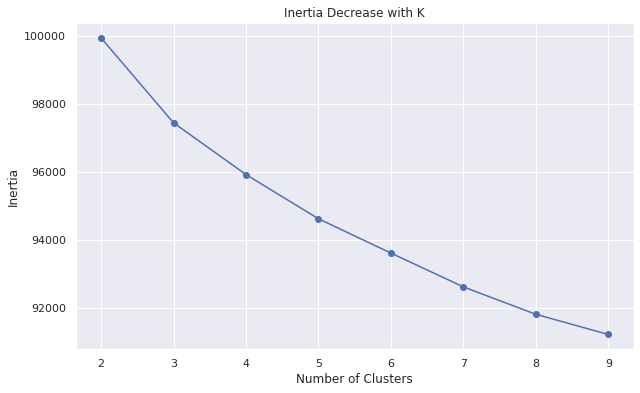

For k-means++ choice of centroids initialization


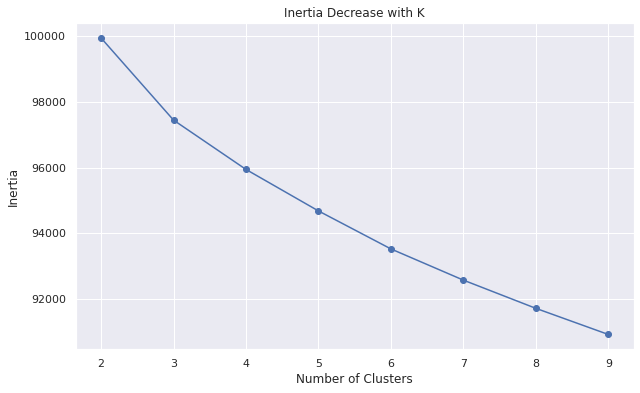

In [155]:
### Fit KMeans after PCA
kmeans_model_pca = KMeans
print('For random choice of centroids initialization')
inertia_plot(kmeans_model_pca, text_vectorized_dims_red, kmeans_init = 'random')

### Fit KMeans++
print('For k-means++ choice of centroids initialization')
inertia_plot(kmeans_model_pca, text_vectorized_dims_red, kmeans_init = 'k-means++' )

Silhouette-Score for 2 Clusters:  0.04179129239065099


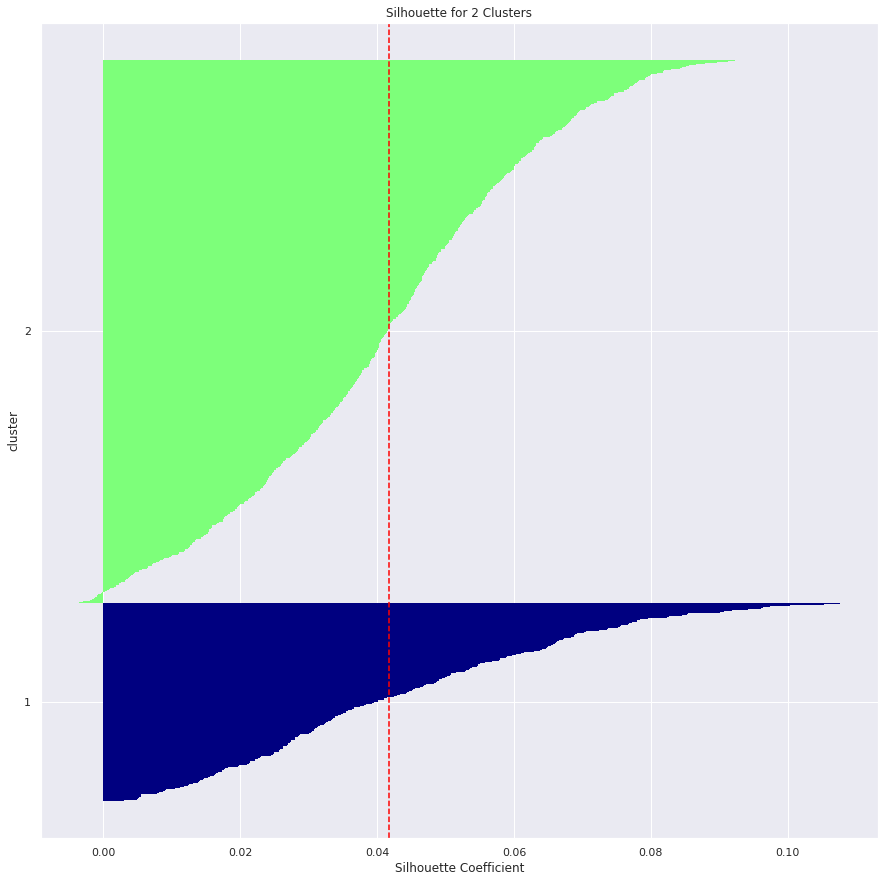

Silhouette-Score for 3 Clusters:  0.019963201433203757


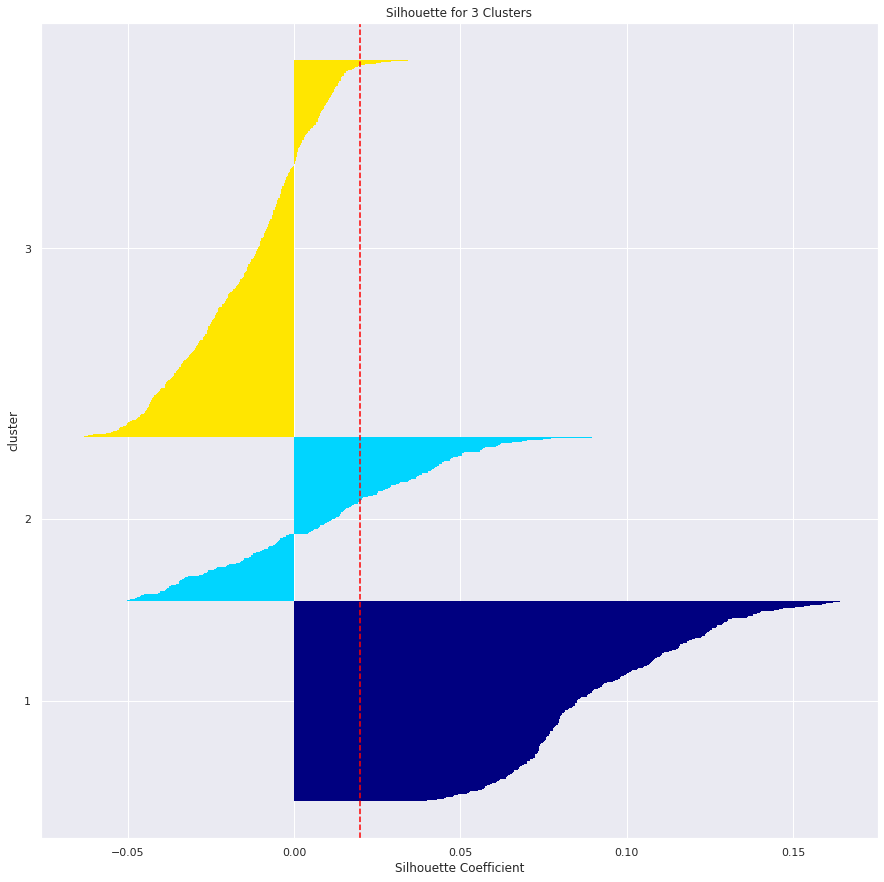

Silhouette-Score for 4 Clusters:  0.009876506677061988


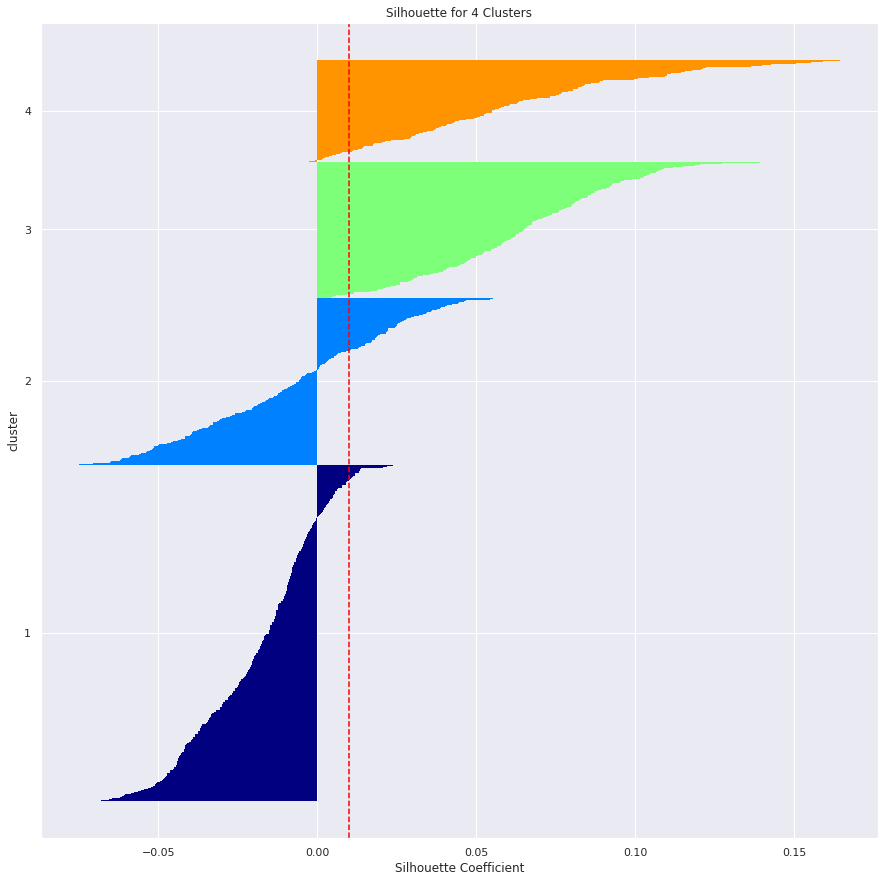

Silhouette-Score for 5 Clusters:  0.014491533283699853


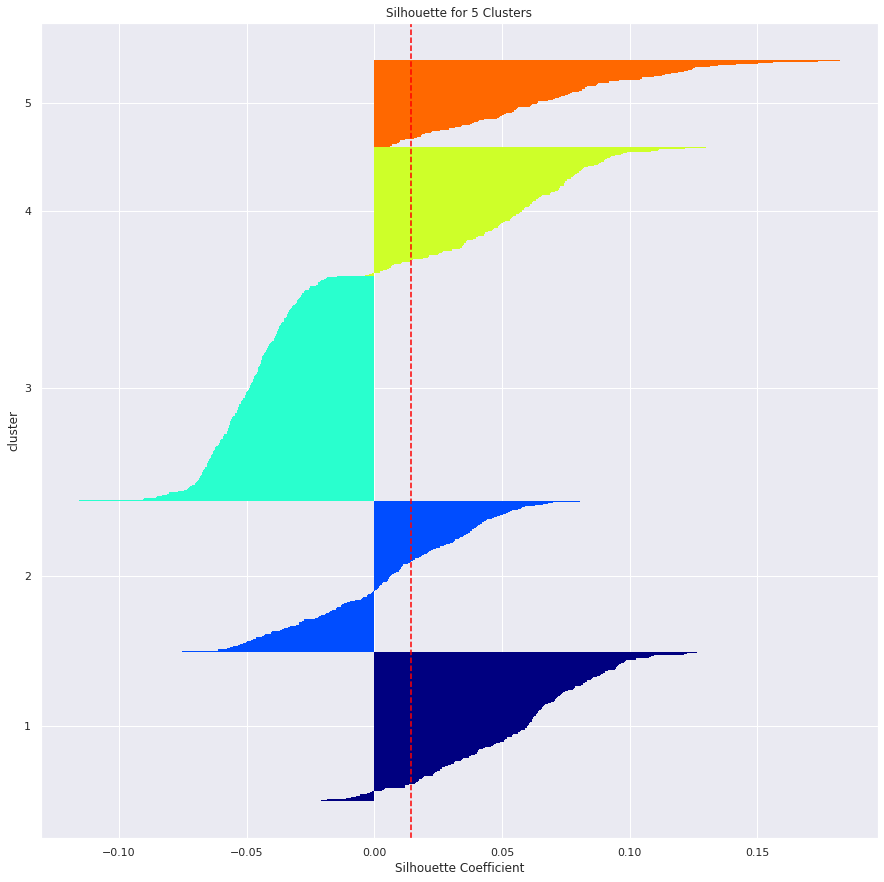

Silhouette-Score for 6 Clusters:  0.018506481270372112


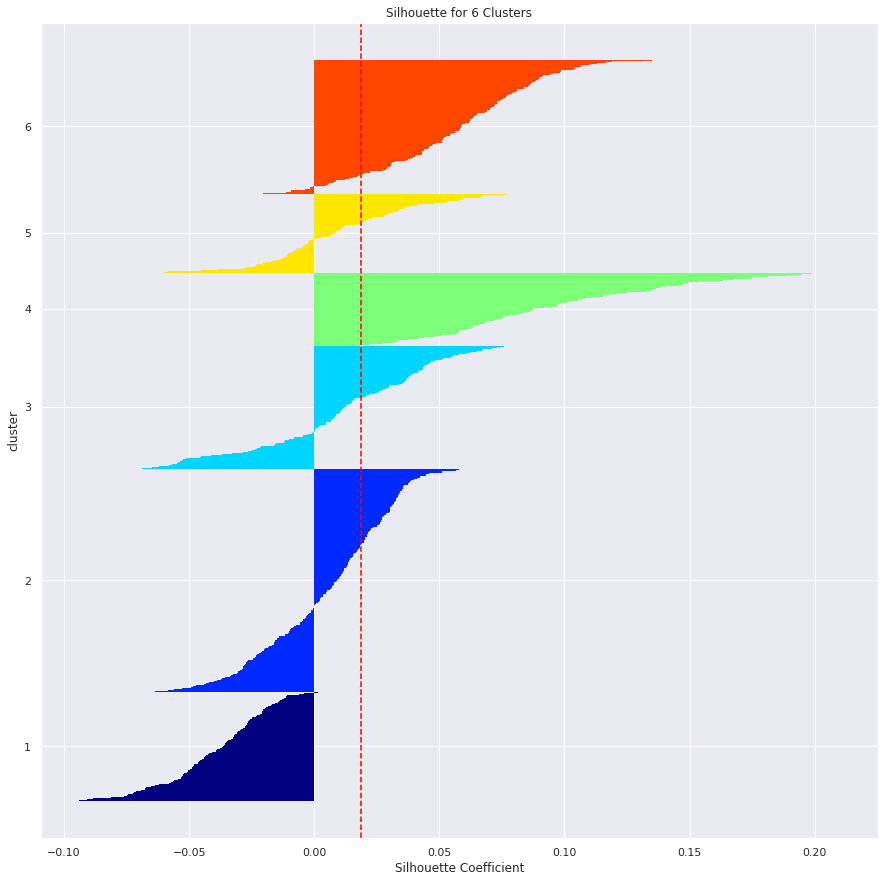

Silhouette-Score for 7 Clusters:  0.01990351902661509


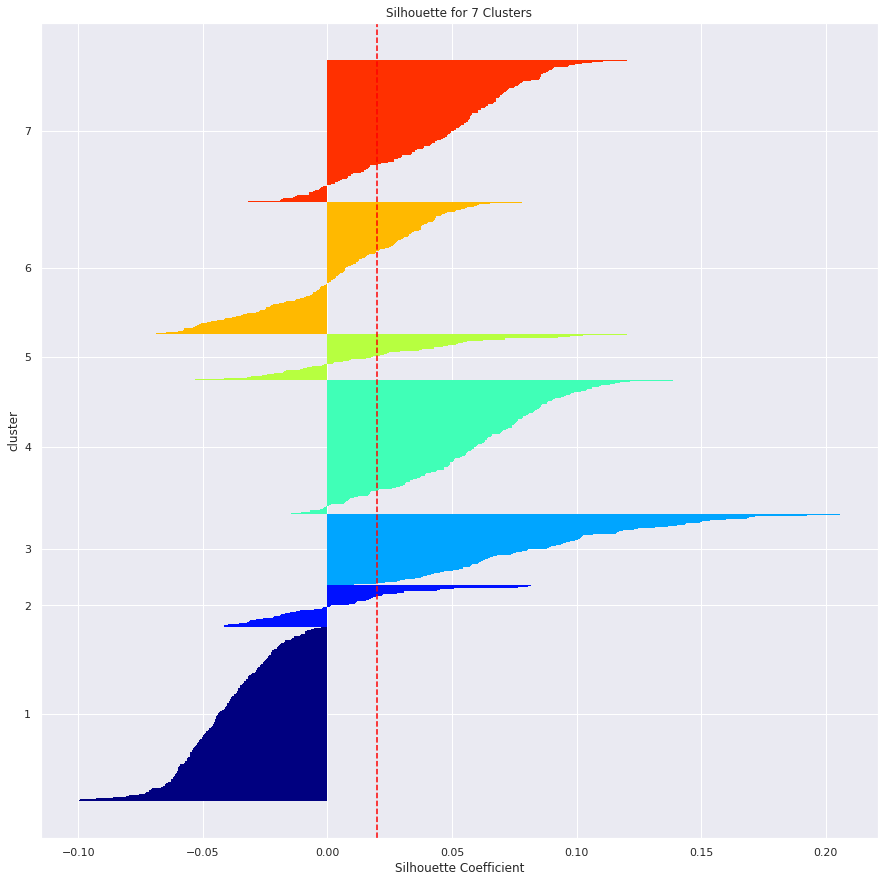

Silhouette-Score for 8 Clusters:  0.018602837519573718


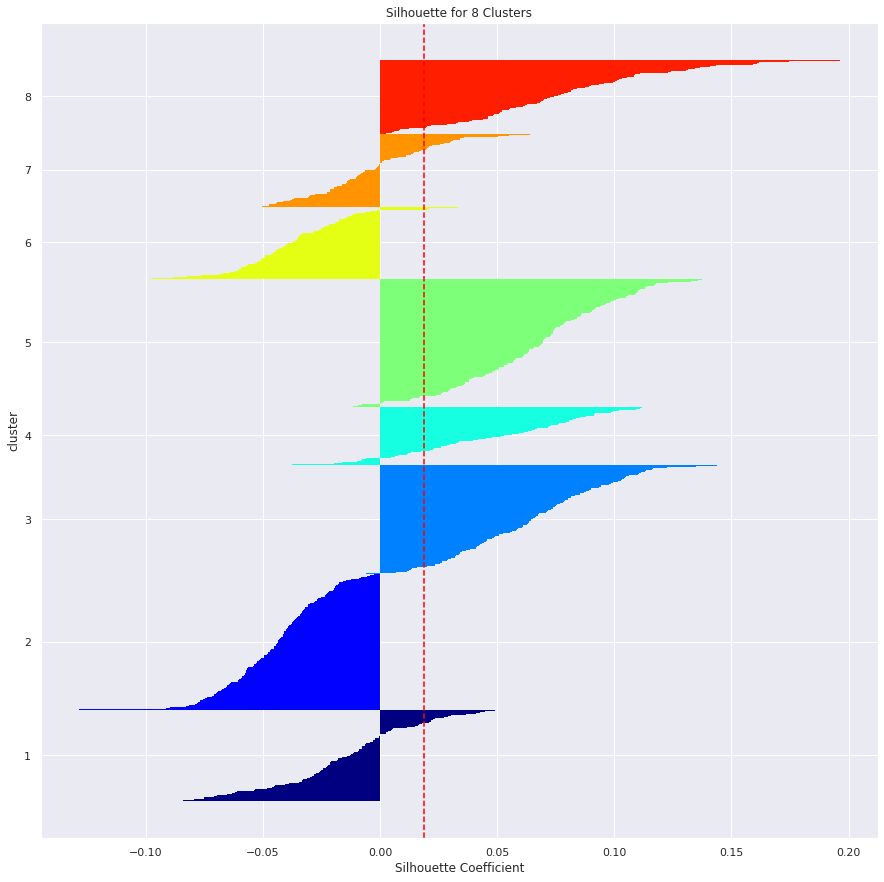

Silhouette-Score for 9 Clusters:  0.027374379220540774


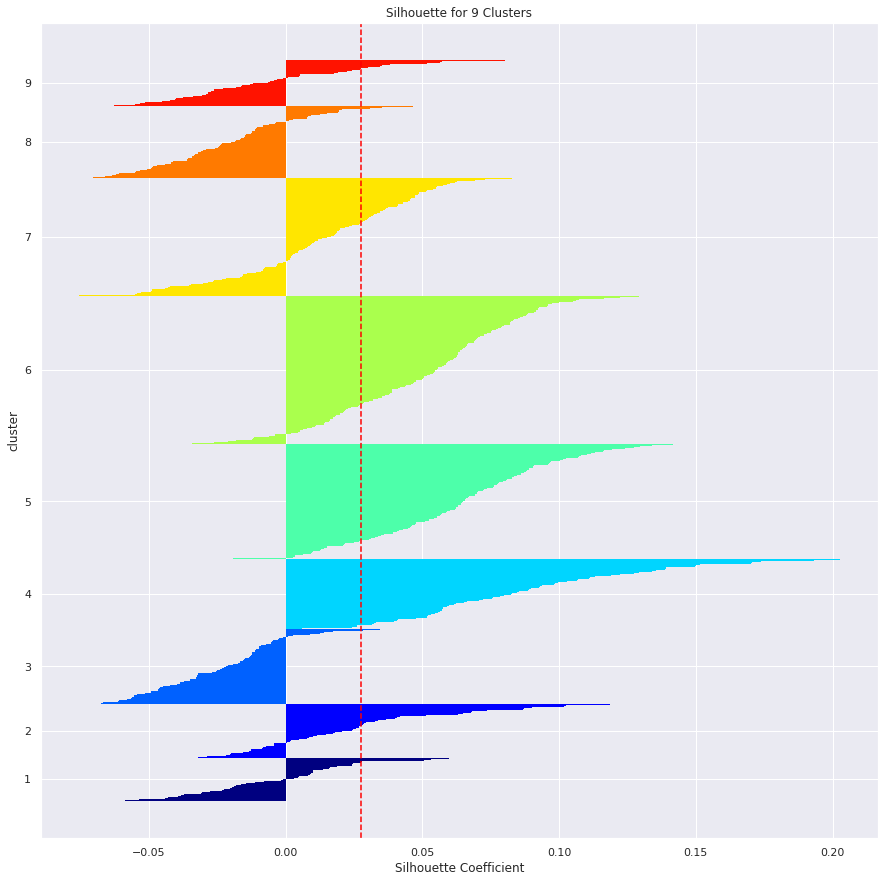

In [156]:
silhoutte_scores_plots(kmeans_model_pca, text_vectorized_dims_red, start = 2, stop = 10)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.009s...
[t-SNE] Computed neighbors for 986 samples in 0.292s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 3.263240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.070152
[t-SNE] KL divergence after 1000 iterations: 2.002184


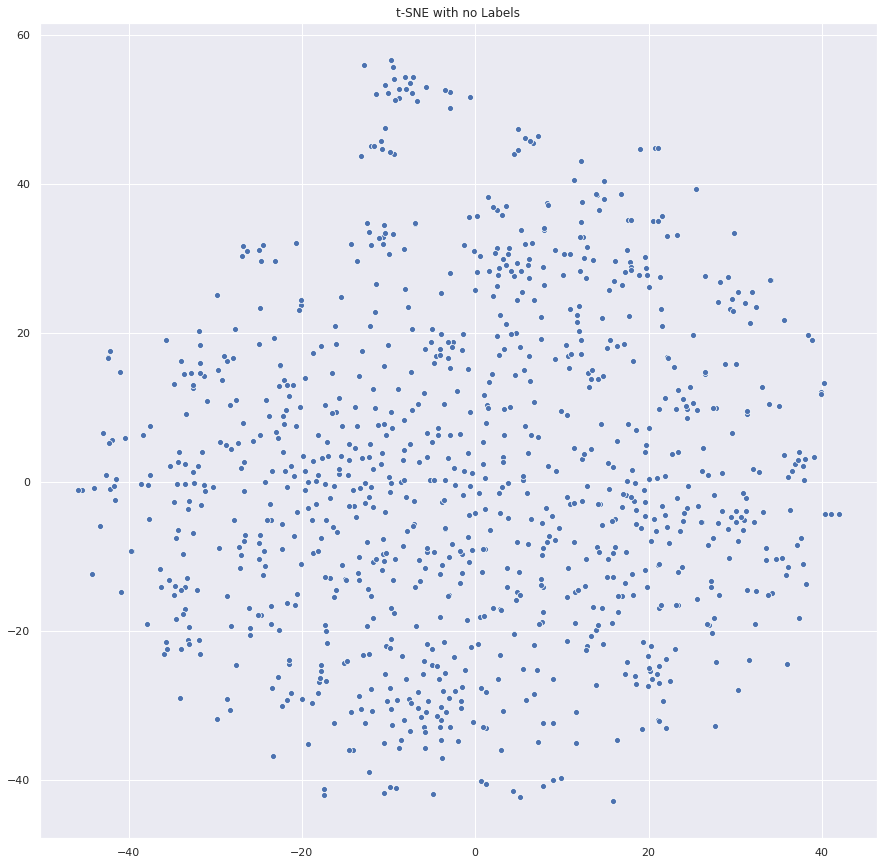

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.008s...
[t-SNE] Computed neighbors for 986 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 3.263240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.070160
[t-SNE] KL divergence after 1000 iterations: 2.002184


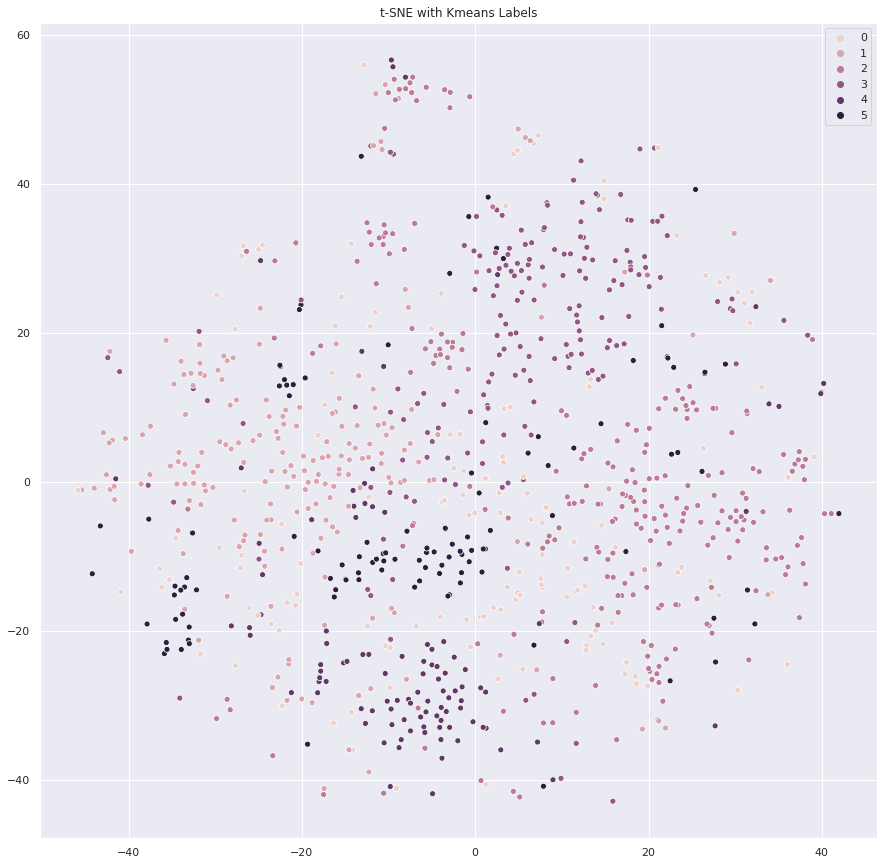

In [157]:
### Now, fit the KMeans with the selected "K" clusters and visualize the data samples and clusters

optimal_k_pca = 6


_ = fit_and_plot(kmeans_model(n_clusters = optimal_k_pca), X = text_vectorized_dims_red, k_selected = optimal_k_pca)

In [158]:
# Function to compute clusters with different linkage and clusters 
def agg_model(X, cluster_limit = 10 , linkage = None):
    # function returns optimal "k" value for number of clusters
    optimal_k_agg_unstruct = None
    silhoutte_score_ = -1
    
    ## Initialize and fit the agglomerative model
    for cluster_size in range (2, cluster_limit):
        agglomerative_model = AgglomerativeClustering(n_clusters= cluster_size, 
                                                  linkage= linkage).fit(X)

        ## Compute and print the silhoutte score 
        silhoutte_score_var = silhouette_score(X, agglomerative_model.labels_)
        print('Silhouette-Score for', cluster_size,  'Clusters: ', silhoutte_score_var)

        if silhoutte_score_var > silhoutte_score_ :
            silhoutte_score_ = silhoutte_score_var
            optimal_k_agg_unstruct = cluster_size
    return optimal_k_agg_unstruct

In [159]:
### Apply the agglomerative clustering to data
print("for the linkage type : ward")
optimal_k_agg_unstruct = agg_model(text_vectorized_dims_red, cluster_limit = 10, linkage = 'ward')

### 
print("for the linkage type : complete")
optimal_k_agg_unstruct_complete = agg_model(text_vectorized_dims_red, cluster_limit = 10, linkage = 'complete')

for the linkage type : ward
Silhouette-Score for 2 Clusters:  0.04357507638316429
Silhouette-Score for 3 Clusters:  0.016169752524472517
Silhouette-Score for 4 Clusters:  0.0011028751414352367
Silhouette-Score for 5 Clusters:  0.0036076756204527103
Silhouette-Score for 6 Clusters:  0.006934332678672919
Silhouette-Score for 7 Clusters:  -0.011507268651674887
Silhouette-Score for 8 Clusters:  -0.009061603326486414
Silhouette-Score for 9 Clusters:  -0.005786383816702095
for the linkage type : complete
Silhouette-Score for 2 Clusters:  0.07316594658033765
Silhouette-Score for 3 Clusters:  0.06173134839444054
Silhouette-Score for 4 Clusters:  0.05995461333800768
Silhouette-Score for 5 Clusters:  0.05556006614457356
Silhouette-Score for 6 Clusters:  0.053240741303368304
Silhouette-Score for 7 Clusters:  0.05051522920058587
Silhouette-Score for 8 Clusters:  0.046761116468303915
Silhouette-Score for 9 Clusters:  0.018166405396489258


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.004s...
[t-SNE] Computed neighbors for 986 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


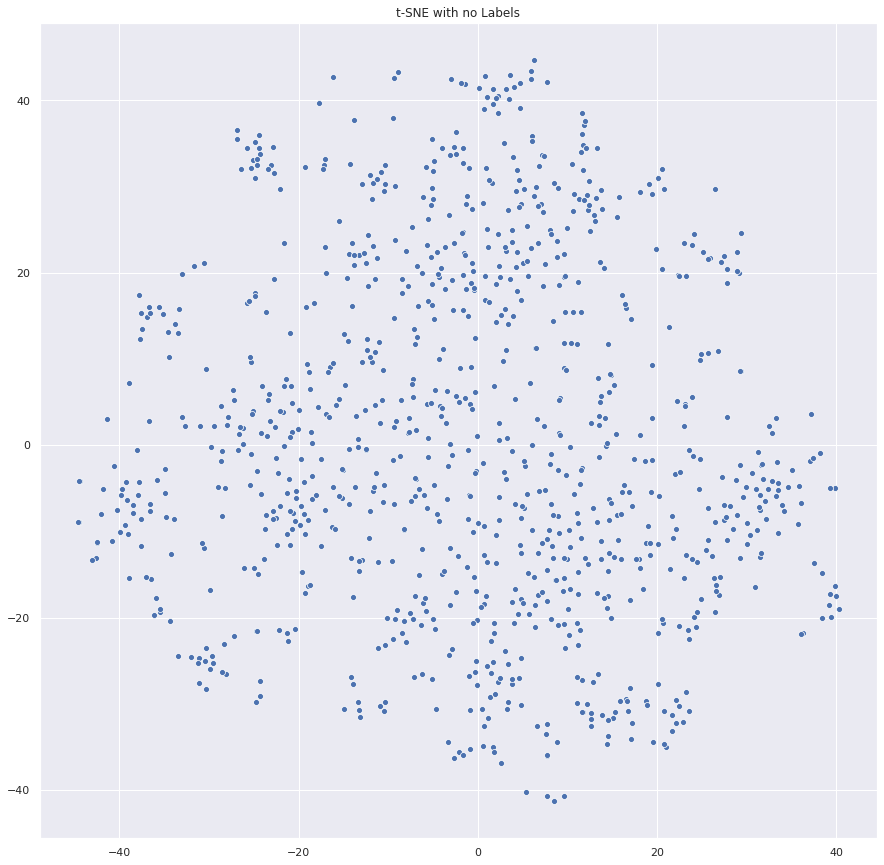

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.006s...
[t-SNE] Computed neighbors for 986 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


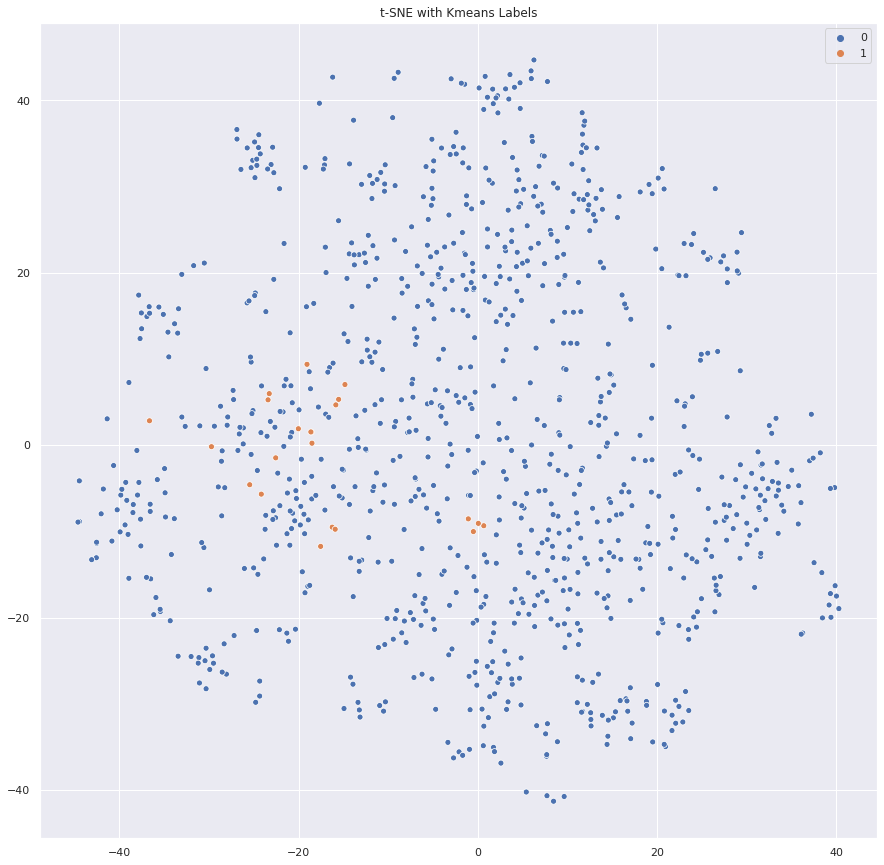

In [133]:
### Fit the best model and visualize the clusters on scatter plot

agglomerative_model_picked = AgglomerativeClustering(n_clusters= optimal_k_agg_unstruct_complete, 
                                              linkage='complete').fit(text_vectorized_dims_red)

_ = fit_and_plot(agglomerative_model_picked, text_vectorized_dims_red, k_selected = optimal_k_agg_unstruct_complete)

###### Structured agglomerative clustering

In [134]:
from sklearn.neighbors import kneighbors_graph

### change this value for computing the kneighbors graph
n_neighbors_considered = 4

### Compute the connectivity graph (matrix form, might be a Compressed Sparse Row (CSR)) for each of the samples using KNeighbors method 
connectivity_graph = kneighbors_graph(text_vectorized_dims_red, 
                                      n_neighbors = n_neighbors_considered, 
                                      mode = 'connectivity', 
                                      metric = 'minkowski', p = 2, 
                                      include_self=False)

In [135]:
connectivity_graph

<986x986 sparse matrix of type '<class 'numpy.float64'>'
	with 3944 stored elements in Compressed Sparse Row format>

In [136]:
# Function to compute clusters with different linkage and clusters 


def agg_connectivity_model(X, cluster_limit = 10 , affinity = 'euclidean', connectivity_graph = None, linkage = None, use_connectivity = False):
    # function returns optimal "k" value for number of clusters
    optimal_k_agg_unstruct = None
    silhoutte_score_ = -1
    ## Initialize and fit the agglomerative model
    for cluster_size in range (2, cluster_limit):
        if (use_connectivity == False) :
            agglomerative_model = AgglomerativeClustering(n_clusters= cluster_size, 
                                                  linkage= linkage).fit(X)
        else:
        ### Initialize clustering model. Options for linkage are : {“ward”, “complete”, “average”, “single”}
            agglomerative_model = AgglomerativeClustering(n_clusters= cluster_size , 
                                              affinity = affinity, ##“euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”##
                                              connectivity= connectivity_graph, 
                                              linkage=linkage).fit(X)

        ## Compute and print the silhoutte score 
        silhoutte_score_var = silhouette_score(X, agglomerative_model.labels_)
        print('Silhouette-Score for', cluster_size,  'Clusters: ', silhoutte_score_var)

        if silhoutte_score_var > silhoutte_score_ :
            silhoutte_score_ = silhoutte_score_var
            optimal_k_agg_unstruct = cluster_size
    return optimal_k_agg_unstruct

In [137]:
print("Compute structured hierarchical clustering...")

optimal_k_agg_struct =agg_connectivity_model(text_vectorized_dims_red, cluster_limit = 10 , affinity = 'euclidean', connectivity_graph = connectivity_graph, linkage = 'complete', use_connectivity = True )

print("Good number of clusters from the agglomerative clustering are : {} " .format(optimal_k_agg_struct))

Compute structured hierarchical clustering...
Silhouette-Score for 2 Clusters:  0.015125721793823325
Silhouette-Score for 3 Clusters:  0.012341041160274645
Silhouette-Score for 4 Clusters:  0.009142611334647914
Silhouette-Score for 5 Clusters:  -0.004048918753005218
Silhouette-Score for 6 Clusters:  -0.007151275632932651
Silhouette-Score for 7 Clusters:  -0.00814232188245575
Silhouette-Score for 8 Clusters:  -0.010470824131022157
Silhouette-Score for 9 Clusters:  -0.012982403507446992
Good number of clusters from the agglomerative clustering are : 2 


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.004s...
[t-SNE] Computed neighbors for 986 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


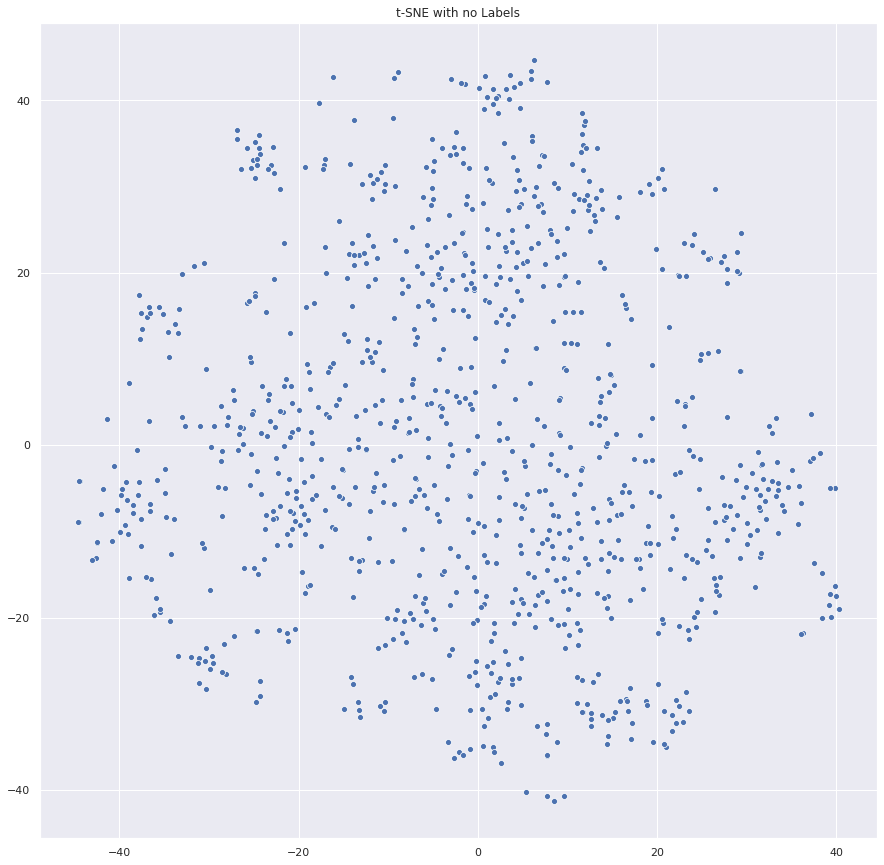

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.004s...
[t-SNE] Computed neighbors for 986 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


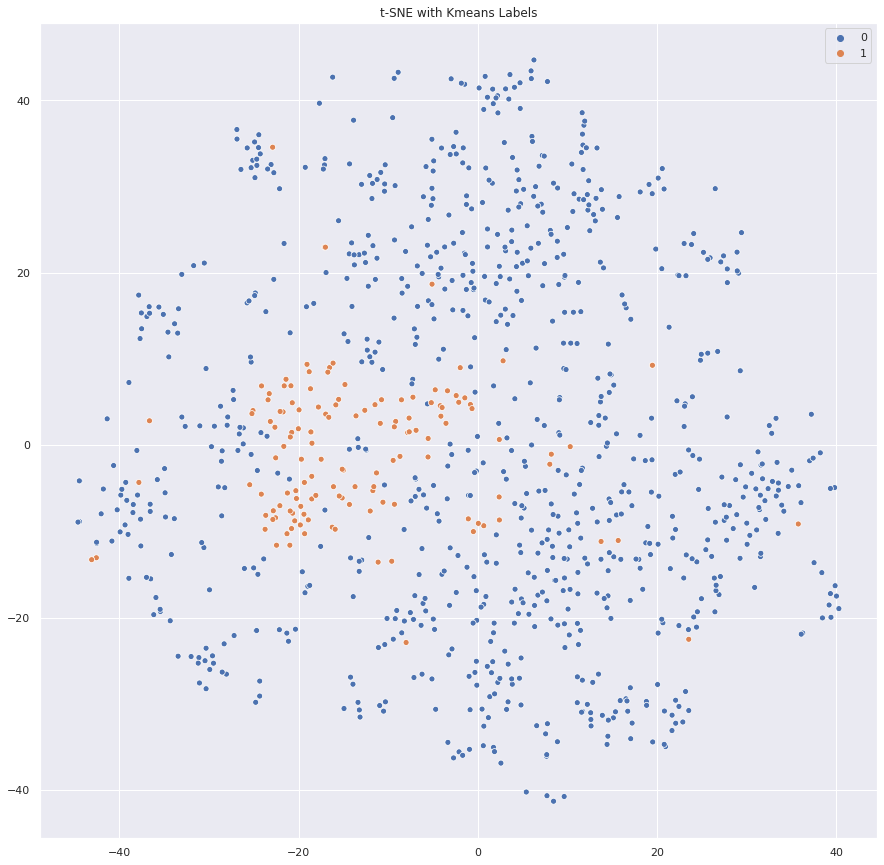

In [138]:
# Use fit_and_plot function to fit the best model and visualize the plot of clusters
agglomerative_connectivity_model_picked = AgglomerativeClustering(n_clusters= optimal_k_agg_struct , 
                                              affinity = 'euclidean', ##“euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”##
                                              connectivity= connectivity_graph, 
                                              linkage='ward').fit(text_vectorized_dims_red)

_ = fit_and_plot(agglomerative_connectivity_model_picked, text_vectorized_dims_red, k_selected = optimal_k_agg_struct)

### GMM

In [139]:
from sklearn.mixture import GaussianMixture

In [140]:
## Function to do Clustering using Gaussian Mixture Model
def gaussian_mixture_model(X, cluster_limit = 10 ):
    # function returns optimal "k" value for number of clusters
    optimal_k_gmm = None
    best_gmm = None
    best_cv_type = None
    bic = []
    lowest_bic = np.infty
    silhoutte_score_ = -np.infty
    cv_types = ['spherical', 'tied', 'diag', 'full']
    ## Initialize and fit the model
    for cluster_size in range (2, cluster_limit):
        for cv_type in cv_types:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components= cluster_size,
                                          covariance_type=cv_type, random_state = 10)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                optimal_k_gmm = cluster_size
                best_cv_type = cv_type
                

            ## Compute and print the silhoutte score 
            silhoutte_score_var = silhouette_score(X, best_gmm.fit_predict(X))
            print('BIC for', cluster_size,  'Clusters and', cv_type, 'covariance type is : ', bic[-1])
            print('Silhouette-Score for', cluster_size,  'Clusters and', cv_type, 'covraince type is : ', silhoutte_score_var)

            if silhoutte_score_var > silhoutte_score_ :
                silhoutte_score_ = silhoutte_score_var
                
                
    return best_gmm, optimal_k_gmm , best_cv_type

In [141]:
best_gmm_model_selected, optimal_k_gmm, best_cov_type = gaussian_mixture_model(text_vectorized_dims_red, cluster_limit = 10)

BIC for 2 Clusters and spherical covariance type is :  165097.06454906537
Silhouette-Score for 2 Clusters and spherical covraince type is :  0.06031576017545402
BIC for 2 Clusters and tied covariance type is :  171859.08995295528
Silhouette-Score for 2 Clusters and tied covraince type is :  0.06031576017545402
BIC for 2 Clusters and diag covariance type is :  161489.8545527459
Silhouette-Score for 2 Clusters and diag covraince type is :  0.005068448796519723
BIC for 2 Clusters and full covariance type is :  172364.4761803381
Silhouette-Score for 2 Clusters and full covraince type is :  0.005068448796519723
BIC for 3 Clusters and spherical covariance type is :  164002.1627631695
Silhouette-Score for 3 Clusters and spherical covraince type is :  0.005068448796519723
BIC for 3 Clusters and tied covariance type is :  171760.79487395892
Silhouette-Score for 3 Clusters and tied covraince type is :  0.005068448796519723
BIC for 3 Clusters and diag covariance type is :  161686.0979784735
Silho

In [142]:
best_gmm_model_selected.covariances_.shape
print('BIC for best Gaussian Mixture model with ', optimal_k_gmm,  'Clusters and', best_cov_type, 'covariance type is : ', best_gmm_model_selected.bic(text_vectorized_dims_red))

BIC for best Gaussian Mixture model with  2 Clusters and diag covariance type is :  161489.8545527459


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.006s...
[t-SNE] Computed neighbors for 986 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


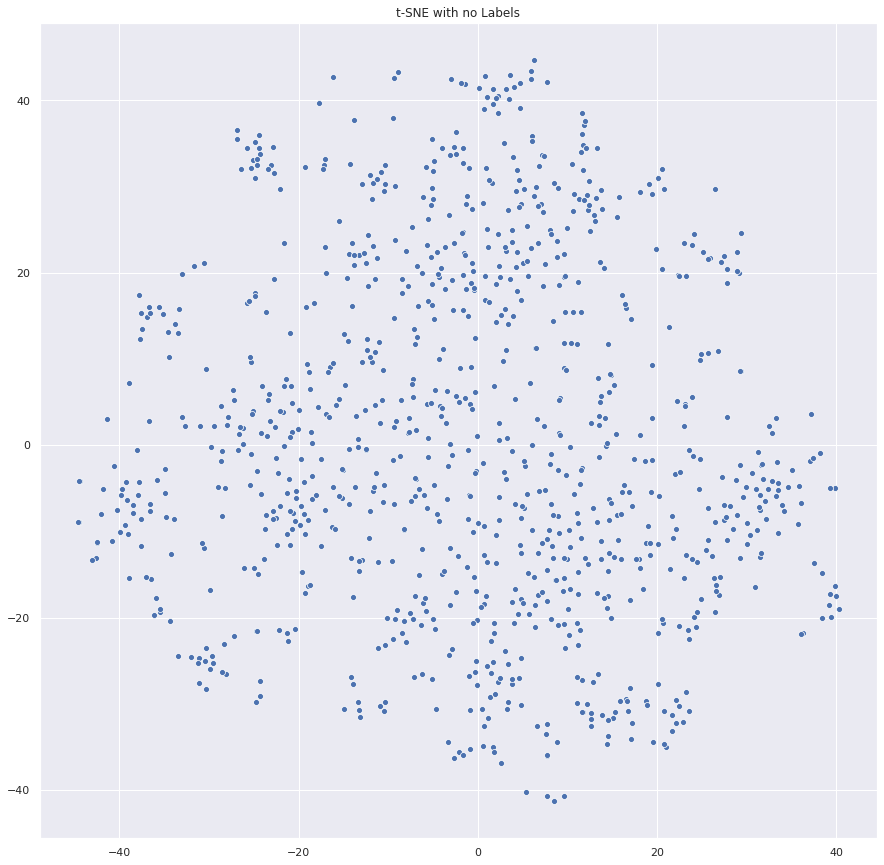

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.006s...
[t-SNE] Computed neighbors for 986 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 2.955530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.015846
[t-SNE] KL divergence after 1000 iterations: 1.798958


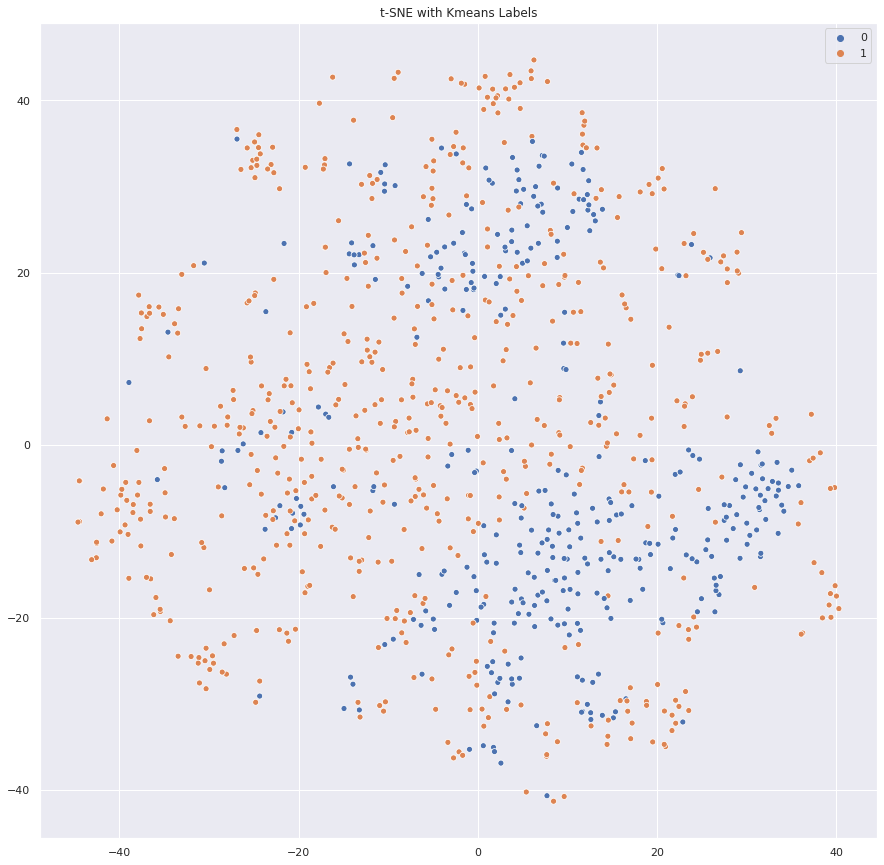

In [143]:
### Using the best model with good hyperparameters, fit the model to data and plot the clusters to visualize them


_ = fit_and_plot(best_gmm_model_selected, text_vectorized_dims_red , k_selected = optimal_k_gmm)



### Spectral Clustering

In [144]:
from sklearn.cluster import SpectralClustering
from networkx.algorithms.cuts import conductance
from scipy.sparse import csgraph
from numpy import linalg as LA
from scipy.spatial.distance import pdist, squareform
import math

In [145]:
### Function to compute the affinity matrix

def affinity_matrix_func(input_matrix, distance_metric = 'euclidean', affinity_metric = 'rbf', gamma = 1.0):
    
    ## Compute the distance matrix from the given input matrix
    distance_matrix = squareform(pdist(input_matrix, metric = 'euclidean'))
    
    ### Compute the affinity matrix from distance matrix using the 'RBF' kernel
    if affinity_metric == 'rbf':
        affinity_matrix = np.exp(-gamma * distance_matrix ** 2)
    else : 
        print("choose the right option for \'affinity_metric\' ")
    
    return affinity_matrix

In [160]:
### Function to compute the eigendecomposition and eigengap.

def eigengap_k(A, plot = True, num_top_k_choices = 1, num_eigenvalues_considered = 100):
    """
    :param A: Affinity matrix (also called similarity matrix)
    :param plot: plots the sorted eigen values for visual inspection
    :param num_eigenvalues_considered: 
            This we need becuase sometime eigen values drop drastically as number of eigen values approach the rank of matrix.
            Also, we don't need number of clusters to be nearly as the number of data points which is not interesting and useful for analysis.
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic

    """
    L = csgraph.laplacian(A, normed=True)
    
    n_components = A.shape[0]
    
    eigenvalues, eigenvectors = LA.eig(L)
    
    print('Number of eigen values are : ' , len(eigenvalues))
    
    ### Sort the eigen values and vectors in descending order.
    sort_indicies = np.flip(eigenvalues.argsort()) # In descending order and argsort here gives ascending order
    eigenvalues_sorted = eigenvalues[sort_indicies]
    eigenvectors_sorted = eigenvectors[:, sort_indicies]
    
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues_sorted)), eigenvalues_sorted)
        plt.xlabel('number of clusters \"k\" ')
        plt.ylabel('eigen values')
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    
    ### This below code eliminates the eigen values that are at position equal to the number of samples 
    ### because we don't need each cluster is assigned to only few points and
    ### that particular clustering is often not useful and interesting
    if num_eigenvalues_considered >= A.shape[0]:
        num_eigenvalues_considered = math.floor((A.shape[0])/2)
    
    eigen_gaps_indicies_sorted = np.argsort(np.abs(np.diff(eigenvalues_sorted[: num_eigenvalues_considered])))[::-1][:num_top_k_choices]

    opt_num_clusters = eigen_gaps_indicies_sorted + 1 ### Add "1" since the argsort reduces number of indicies by 1
    
    ### Remove "1" from cluster numbers since we don't need only one cluster of big size and it's nothing useful for analysis.
    opt_num_clusters = opt_num_clusters[ opt_num_clusters >= 2 ]
    
    return opt_num_clusters, eigenvalues_sorted, eigenvectors_sorted

In [225]:
### Function to do spectral clustering. Here, I have implemented the Andrew Ng's algorithm. 

def spectral_clustering_model(X, cluster_limit = 11 , n_components = None, gamma = 1.0, affinity = 'rbf' , assign_labels= 'kmeans'):
    # function returns optimal "k" value for number of clusters
    optimal_k_spec = None
    silhoutte_score_ = -1
    best_spectral_model = None
    
    ### First, compute affinity matrix 
    affinity_matrix = affinity_matrix_func(X, distance_metric = 'euclidean', affinity_metric = 'rbf', gamma = 1.0 )
    
    
    ### Second, use the affinity matrix to determine the right choice for "k"
    cluster_sizes, _, _ = eigengap_k(affinity_matrix, plot = True, num_top_k_choices = 5, num_eigenvalues_considered = 100 )
    print('Right choices of \'k\' for spectral clustering through Eigengap heuristic would be (in decreasing order of importance): ', cluster_sizes)
    
    cluster_size = cluster_sizes[0]
    
    ### Third, fit the spectral clustering model with selected "k" for number of clusters
    
    #for cluster_size in cluster_sizes:
        ### Initialize clustering model.
    spectral_cluster_model = SpectralClustering(n_clusters= cluster_size, 
                                                   eigen_solver='arpack', 
                                                   n_components= cluster_size,  # Number of eigen vectors in embedding space
                                                   random_state=10, 
                                                   gamma = gamma,                 # Kernel coefficient - defines the strength or spread of the kernel
                                                   affinity='rbf',  
                                                   assign_labels = assign_labels , 
                                                   n_jobs = -1)

    spectral_cluster_model.fit(X)

    ## Compute and print the silhoutte score 
    silhoutte_score_var = silhouette_score(X, spectral_cluster_model.labels_)
    print('Silhouette-Score for', cluster_size,  'Clusters: ', silhoutte_score_var)

    if silhoutte_score_var > silhoutte_score_ :
                silhoutte_score_ = silhoutte_score_var
                optimal_k_spec = cluster_size
                best_spectral_model = spectral_cluster_model                
                
    return best_spectral_model, optimal_k_spec

Number of eigen values are :  986
Right choices of 'k' for spectral clustering through Eigengap heuristic would be (in decreasing order of importance):  [96 94 95 99 87]


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:319: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (96). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


Silhouette-Score for 96 Clusters:  -0.015113865832798749


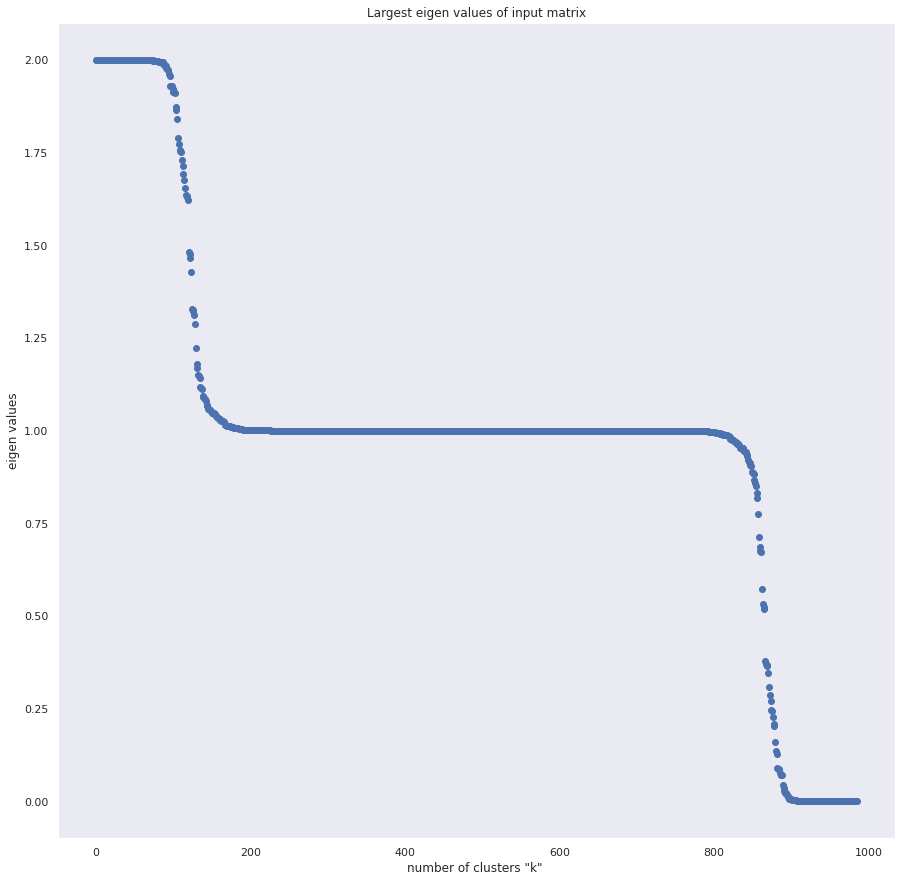

In [226]:
### Note: use the appropriate data since we have to find the spectral embedding for the data samples during clustering.

best_spectral_model_selected, optimal_k_spectral = spectral_clustering_model(text_vectorized_dims_red, cluster_limit = 10, gamma = 1.0 , affinity = 'rbf', assign_labels = 'kmeans')

In [227]:
optimal_k_spectral

96

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:319: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (96). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.010s...
[t-SNE] Computed neighbors for 986 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 3.263240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.070152
[t-SNE] KL divergence after 1000 iterations: 2.002184


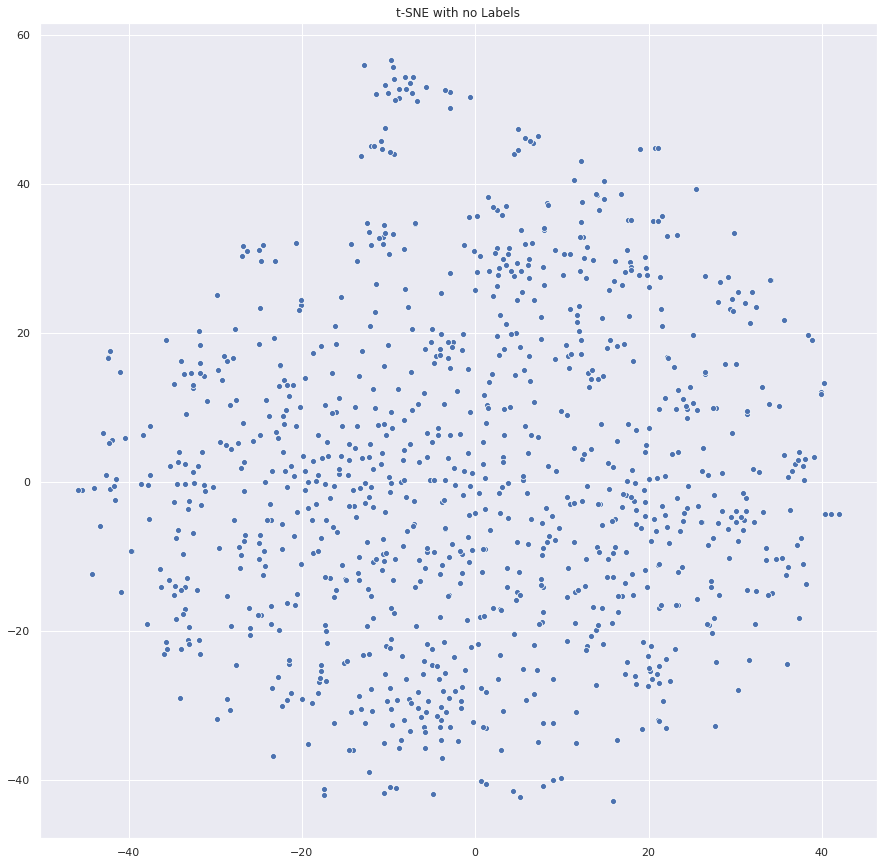

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.007s...
[t-SNE] Computed neighbors for 986 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 3.263240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.070152
[t-SNE] KL divergence after 1000 iterations: 2.002184


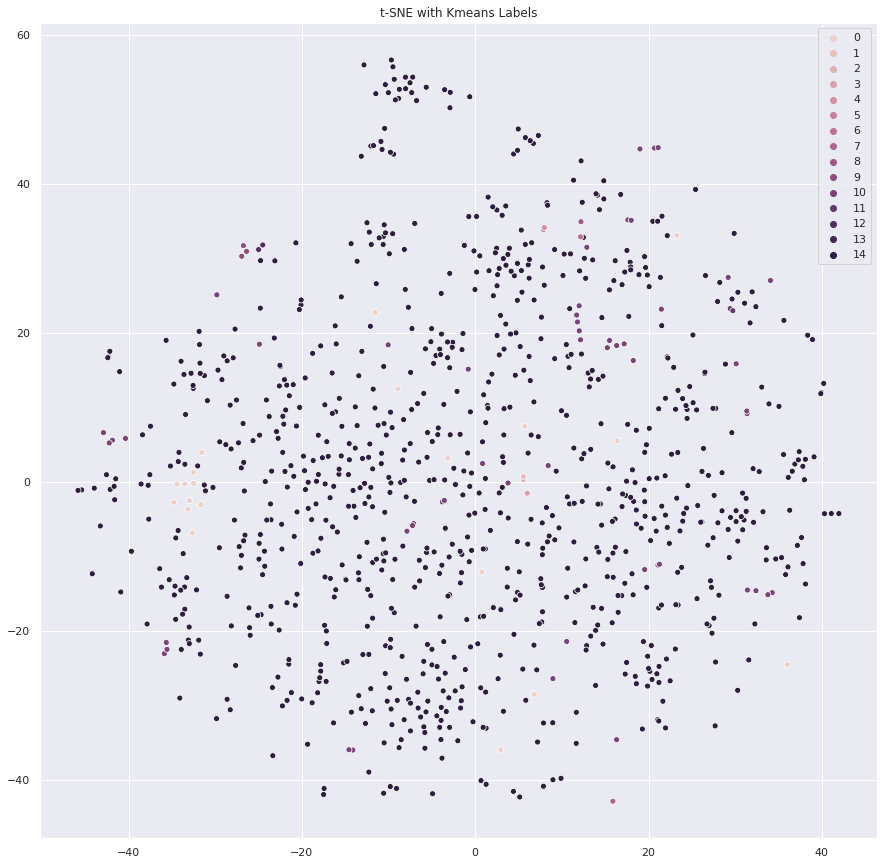

In [228]:
### Using the best model with good hyperparameters, fit the model to data and plot the clusters to visualize them

tsne_embedded_data = fit_and_plot(best_spectral_model_selected, text_vectorized_dims_red , k_selected = optimal_k_spectral)

##### Add the predicted cluster labels to the original data

In [235]:
filtered_data_df['y'] = best_spectral_model_selected.labels_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Topic modelling on each cluster

In [231]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [232]:
num_clusters_selected = optimal_k_spectral

In [233]:
def count_vectorization(df, num_clusters):
    
    vectorizers = []

    for x in range(0, num_clusters):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    
    vectorized_data = []

    for current_cluster, cvec in enumerate(vectorizers):
        try:
            vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
        except Exception as e:
            print("Not enough instances in cluster: " + str(current_cluster))
            vectorized_data.append(None)
            
    return vectorized_data, vectorizers

In [234]:
clusters_vectorized_data, vectorizers = count_vectorization(filtered_data_df, num_clusters_selected )

Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 5
Not enough instances in cluster: 6
Not enough instances in cluster: 7
Not enough instances in cluster: 8
Not enough instances in cluster: 9
Not enough instances in cluster: 10
Not enough instances in cluster: 12
Not enough instances in cluster: 13
Not enough instances in cluster: 14
Not enough instances in cluster: 18
Not enough instances in cluster: 25
Not enough instances in cluster: 26
Not enough instances in cluster: 31
Not enough instances in cluster: 33
Not enough instances in cluster: 36
Not enough instances in cluster: 47
Not enough instances in cluster: 51
Not enough instances in cluster: 53
Not enough instances in cluster: 56
Not enough instances in cluster: 58
Not enough instances in cluster: 60
Not enough instances in cluster: 61
Not enough instances in cluster: 72
Not enough instances in cluster: 74
Not enough instances in cluster: 80
Not enough instances in cluster: 81

In [236]:
def lda_models(vectorized_data, num_clusters, num_topics_per_cluster = 20):
    # number of topics per cluster
    NUM_TOPICS_PER_CLUSTER = num_topics_per_cluster

    lda_models = []
    for x in range(0, num_clusters):
        # Latent Dirichlet Allocation Model
        lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
        lda_models.append(lda)

    # lda_models[0]
    
    clusters_lda_data = []

    for current_cluster, lda in enumerate(lda_models):
        # print("Current Cluster: " + str(current_cluster))
        if vectorized_data[current_cluster] != None:
            clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
    
    return clusters_lda_data, lda_models

In [237]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [238]:
clusters_lda_data, lda_models = lda_models(clusters_vectorized_data, num_clusters_selected, num_topics_per_cluster = 10)

In [255]:
filtered_data_df['keywords'] = np.nan
filtered_data_df['keywords'] = filtered_data_df['keywords'].astype(np.object)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [258]:
all_keywords = []
for cluster_id, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))
    
    print("Perplexity score of lda model for ", cluster_id , "cluster is : " , lda_models.bound_)

    if clusters_vectorized_data[cluster_id] != None:
        all_keywords.append(selected_topics(lda, vectorizers[cluster_id]))
        filtered_data_df['keywords'] = np.where((filtered_data_df['y'] == cluster_id), str(all_keywords[-1]), filtered_data_df['keywords'] )
    else : 
        filtered_data_df['keywords'] = np.where((filtered_data_df['y'] == cluster_id), None, filtered_data_df['keywords'] )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [267]:
filtered_data_df.loc[filtered_data_df['y'] == 7, 'keywords']

56157    None
62137    None
Name: keywords, dtype: object

In [ ]:
topics_file = open('topics.txt','w')

count = 0

for ii in all_keywords:

    if clusters_vectorized_data[count] != None:
        topics_file.write(', '.join(ii) + "\n")
    else:
        topics_file.write("Not enough instances to be determined. \n")
        topics_file.write(', '.join(ii) + "\n")
    count += 1

topics_file.close()

#### Save the results for visualization

In [ ]:
import pickle

In [ ]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(filtered_data_df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(tsne_embedded_data, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(list(filtered_data_df['y']), open("y_pred.p", "wb" ))

In [ ]:
results_df = filtered_data_df

In [ ]:
results_df["tsne_embedding_coord1"] = tsne_embedded_data[:, 0]
results_df["tsne_embedding_coord2"] = tsne_embedded_data[:, 1]

In [ ]:
results_df

In [ ]:
results_df.to_csv('results_dataframe.csv', index=False)